In [1]:
%matplotlib inline

In [2]:
import centrosome.haralick
import mahotas
import matplotlib.pyplot
import numpy
import skimage.io

/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


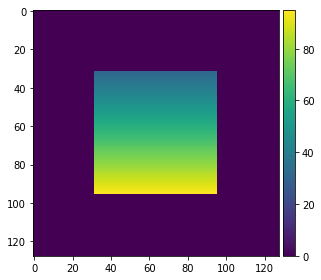

In [3]:
image, _ = numpy.mgrid[0:128, -64:64]

labels = numpy.zeros_like(image, dtype=numpy.uint8)
labels[32:96, 32:96] = 1

label_data = numpy.zeros_like(image)
label_data[labels == 1] = image[labels == 1]

skimage.io.imshow(label_data)

In [4]:
scale = 3

In [5]:
# CellProfiler 2.0 equivalent
h_horizontal = centrosome.haralick.Haralick(image, labels, 0, scale).all()

In [6]:
# CellProfiler 3.0 equivalent
h_mahotas = mahotas.features.haralick(label_data, distance=scale, ignore_zeros=True)
h_mahotas_zeros = mahotas.features.haralick(label_data, distance=scale)

In [7]:
h_horizontal

[array([ 0.125]),
 array([ 0.]),
 array([ 1.]),
 array([ 5.25]),
 array([ 1.]),
 array([ 9.]),
 array([ 21.]),
 array([ 2.07944154]),
 array([ 2.07944154]),
 array([ 0.]),
 array([ -2.22044605e-16]),
 array([-1.]),
 array([ 0.99215674])]

In [8]:
h_mahotas[0]  # this is close to h_horizontal, with a few exceptions (and order of magnitude)

array([  1.56250000e-02,   0.00000000e+00,   1.00000000e+00,
         3.41250000e+02,   1.00000000e+00,   1.27000000e+02,
         1.36500000e+03,   6.00000000e+00,   6.00000000e+00,
         1.03081597e-02,  -0.00000000e+00,  -1.00000000e+00,
         9.99996928e-01])

In [9]:
h_mahotas_zeros[0]  # nope.

array([  5.36758750e-01,   1.04964000e+02,   9.38643268e-01,
         8.55358464e+02,   9.76007973e-01,   3.25120000e+01,
         3.31646986e+03,   2.53400977e+00,   2.58715299e+00,
         9.81425347e-03,   3.07345543e-01,  -9.02190461e-01,
         9.92858730e-01])

In [10]:
import numpy as np

class Haralick2(centrosome.haralick.Haralick):
    """
    Calculate the Haralick texture features.
    Currently, the implementation uses nevels = 8 different grey
    levels.
    The original reference is: Haralick et al. (1973), Textural
    Features for Image Classification, _IEEE Transaction on Systems
    Man, Cybernetics_, SMC-3(6):610-621.  BEWARE: There are lots of
    erroneous formulas for the Haralick features in the
    literature.  There is also an error in the original paper.
    """
    def __init__(self, image, labels, scale_i, scale_j, nlevels=8, mask=None):
        """
        image   -- 2-D numpy array of 32-bit floating-point numbers.
        labels  -- 2-D numpy array of integers.
        scale   -- an integer.
        nlevels -- an integer
        """
        if mask is not None:
            labels = labels.copy()
            labels[~mask] = 0
#         normalized = normalized_per_object(image, labels)
#         quantized = centrosome.haralick.quantize(image, nlevels)
        self.P,nlevels = centrosome.haralick.cooccurrence(image, labels, scale_i, scale_j)

        self.nobjects = labels.max()
        px = self.P.sum(2) # nobjects x nlevels
        py = self.P.sum(1) # nobjects x nlevels
        #
        # Normalize px and py to deal with roundoff errors in sums
        #
        px = px / np.sum(px,1)[:,np.newaxis]
        py = py / np.sum(py,1)[:,np.newaxis]
        self.nlevels = nlevels
        self.levels = np.arange(nlevels)
        self.rlevels = np.tile(self.levels, (self.nobjects, 1))
        self.levels2 = np.arange(2 * nlevels - 1)
        self.rlevels2 = np.tile(self.levels2, (self.nobjects, 1))
        self.mux = ((self.rlevels + 1) * px).sum(1)
        mux = np.tile(self.mux, (nlevels,1)).transpose()
        self.muy = ((self.rlevels + 1) * py).sum(1)
        muy = np.tile(self.muy, (nlevels,1)).transpose()
        self.sigmax = np.sqrt(((self.rlevels + 1 - mux) ** 2 * px).sum(1))
        self.sigmay = np.sqrt(((self.rlevels + 1 - muy) ** 2 * py).sum(1))
        eps = np.finfo(float).eps
        self.hx = -(px * np.log(px + eps)).sum(1)
        self.hy = -(py * np.log(py + eps)).sum(1)
        pxpy = np.array([np.dot(px[i,:,np.newaxis], py[i,np.newaxis])
                         for i in range(self.nobjects)]).reshape(self.P.shape)
        self.hxy1 = -(self.P * np.log(pxpy + eps)).sum(2).sum(1)
        self.hxy2 = -(pxpy * np.log(pxpy + eps)).sum(2).sum(1)
        self.eps = eps

        self.p_xplusy = np.zeros((self.nobjects, 2 * nlevels - 1))
        self.p_xminusy = np.zeros((self.nobjects, nlevels))
        for x in self.levels:
            for y in self.levels:
                self.p_xplusy[:, x + y] += self.P[:, x, y]
                self.p_xminusy[:, np.abs(x - y)] += self.P[:, x, y]

In [11]:
# remove the per-object normalization and discretization 
h2_horizontal = Haralick2(image, labels, 0, scale).all()

In [12]:
h2_horizontal

[array([ 0.015625]),
 array([ 0.]),
 array([ 1.]),
 array([ 341.25]),
 array([ 1.]),
 array([ 129.]),
 array([ 1365.]),
 array([ 4.15888308]),
 array([ 4.15888308]),
 array([ 0.]),
 array([ -2.22044605e-16]),
 array([-1.]),
 array([ 0.99987792])]

In [13]:
h_mahotas[0]  # same order of magnitude, some disagreement

array([  1.56250000e-02,   0.00000000e+00,   1.00000000e+00,
         3.41250000e+02,   1.00000000e+00,   1.27000000e+02,
         1.36500000e+03,   6.00000000e+00,   6.00000000e+00,
         1.03081597e-02,  -0.00000000e+00,  -1.00000000e+00,
         9.99996928e-01])